# Description

The purpose of this work is to implement a neural network for classification problem.

In [1]:
import torch
import random
import numpy as np
import pandas as pd

import sklearn.datasets
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# Tasks

Task 1. Classify wines using wine dataset from sklearn library.

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

__Data preparation__

In [3]:
wine = sklearn.datasets.load_wine()
print('Data shape: ', wine.data.shape)

Data shape:  (178, 13)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(wine.data[:, :2], wine.target, test_size=0.3, shuffle=True)
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

__Model__

In [5]:
class WineNet(torch.nn.Module):
    
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        
        self.fc3 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ3 = torch.nn.Sigmoid()
        
        self.fc4 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        x = self.activ3(x)
        x = self.fc4(x)
        return x
    
    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x

In [6]:
wine_net = WineNet(10)
wine_net

WineNet(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (activ1): Sigmoid()
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (activ2): Sigmoid()
  (fc3): Linear(in_features=10, out_features=10, bias=True)
  (activ3): Sigmoid()
  (fc4): Linear(in_features=10, out_features=3, bias=True)
  (sm): Softmax(dim=1)
)

__Loss and Optimizer__

In [7]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(wine_net.parameters(), lr=1.0e-3)

__Model training__

In [8]:
batch_size = 10

for epoch in range(5000):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = wine_net.forward(x_batch)
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    if epoch % 500 == 0:
        test_preds = wine_net.forward(X_test)
        test_preds = test_preds.argmax(dim=1)
        print((test_preds == y_test).float().mean())

tensor(0.4074)
tensor(0.4444)
tensor(0.5370)
tensor(0.6296)
tensor(0.6852)
tensor(0.7222)
tensor(0.7407)
tensor(0.8333)
tensor(0.8519)
tensor(0.8704)


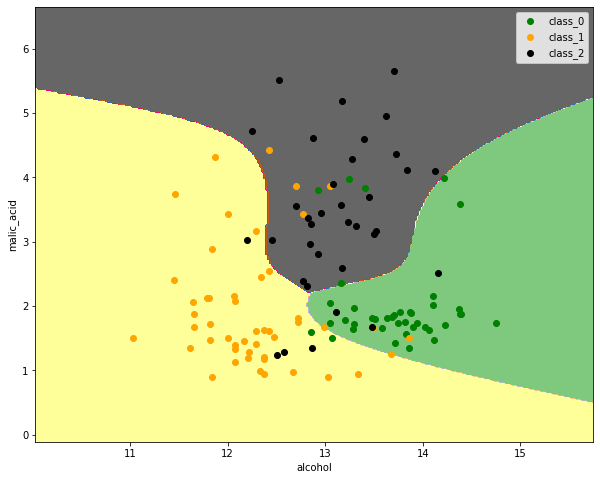

In [9]:
plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy = torch.meshgrid(torch.arange(x_min, x_max, plot_step), 
                        torch.arange(y_min, y_max, plot_step))

preds = wine_net.inference(torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))
preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0], X_train[indexes, 1], c=color, label=wine.target_names[i], cmap='Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()

Task 2. Solve the classification problem on the example of the Breast Cancer Wisconsin (Diagnostic) data
set (can be downloaded from the sklearn library).

__Data preparation__

In [10]:
breast_cancer_df = sklearn.datasets.load_breast_cancer()
print('Data shape: ', breast_cancer_df.data.shape)

Data shape:  (569, 30)


In [11]:
X, y = breast_cancer_df.data, breast_cancer_df.target
X = pd.DataFrame(X, columns=breast_cancer_df['feature_names'])

In [12]:
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr(method='pearson')
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname]

In [13]:
correlation(X, 0.9)
X = X.to_numpy()
print('Data shape: ', X.shape)

Data shape:  (569, 21)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)